In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import numpy as np
import glob
import os
import random

import matplotlib.pyplot as plt 

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
! git clone https://github.com/Taariq78/voxelmorph.git

Cloning into 'voxelmorph'...
remote: Enumerating objects: 2124, done.
remote: Total 2124 (delta 0), reused 0 (delta 0), pack-reused 2124
Receiving objects: 100% (2124/2124), 128.88 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (1337/1337), done.
Checking out files: 100% (75/75), done.


In [ ]:
from voxelmorph.pytorch.model import SpatialTransformer

In [ ]:
import validate

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

#'''unet_start'''
#        '''encoder'''
        self.conv_0=nn.Conv2d(2,16,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_1=nn.Conv2d(16,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_2=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))
        self.conv_3=nn.Conv2d(32,32,kernel_size=(4,4), stride= (2,2), padding=(1,1))

        self.activation=nn.LeakyReLU(negative_slope=0.2)
        

#        '''decoder'''
        self.conv_0_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_1_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2_dec=nn.Conv2d(64,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_3_dec=nn.Conv2d(48,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_4_dec=nn.Conv2d(32,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_5_dec=nn.Conv2d(34,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

#        '''upsample'''
        self.upsample=nn.Upsample(scale_factor=2.0, mode='nearest')
#'''unet_end'''

        self.conv_vm2=nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.conv_flow=nn.Conv2d(16,2,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.spatial_transform = SpatialTransformer((256,256))

    def Unet(self, image_pair):
#          '''encode'''
      x1=self.conv_0(image_pair)
      x1=self.activation(x1)

      x2=self.conv_1(x1)
      x2=self.activation(x2)

      x3=self.conv_2(x2)
      x3=self.activation(x3)

      x4=self.conv_3(x3)
      x4=self.activation(x4)

#          '''decode'''
      y=self.conv_0_dec(x4)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x3],1)

      y=self.conv_1_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x2],1)

      y=self.conv_2_dec(y)
      y=self.activation(y)
      y=self.upsample(y)
      y=torch.cat([y,x1],1)

      y=self.conv_3_dec(y)
      y=self.activation(y)          
      y=self.conv_4_dec(y)
      y=self.activation(y)

      y=self.upsample(y)
      y=torch.cat([y,image_pair],1)
      y=self.conv_5_dec(y)
      y=self.activation(y)

      y=self.conv_vm2(y)
      y=self.activation(y)

      return y

    def forward(self,mov,fix):
      z = torch.cat([mov, fix], dim=1)
      z = self.Unet(z)
      #print(z.shape)
      flow = self.conv_flow(z)
      #print(flow.shape)

      z=self.spatial_transform(mov,flow)   

      return z, flow  



model=Net().to(device)

In [ ]:
model=Net()
model.to(device)

Net(
  (conv_0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (activation): LeakyReLU(negative_slope=0.2)
  (conv_0_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_dec): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_dec): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4_dec): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5_dec): Conv2d(34, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (conv_vm2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_flo

In [ ]:
data_dir='/content/drive/My Drive/2020/Thesis/Data/Voxel_Training/Siddon/Chest/Patient_X'
train_vol_names = glob.glob(os.path.join(data_dir, '*.npz'))

In [ ]:
random.shuffle(train_vol_names)

In [ ]:
ten_split = np.array_split(train_vol_names, 10)

In [ ]:
fold_0 = ten_split[0]
fold_1 = ten_split[1]
fold_2 = ten_split[2]
fold_3 = ten_split[3]
fold_4 = ten_split[4]
fold_5 = ten_split[5]
fold_6 = ten_split[6]
fold_7 = ten_split[7]
fold_8 = ten_split[8]
fold_9 = ten_split[9]

In [ ]:
set_0 = []
'''holdout - fold 0'''
for g in range(0,10):
  if g == 0:
    continue
  set_0.extend(ten_split[g]) 

In [ ]:
set_1 = []
'''holdout - fold 1'''
for g in range(0,10):
  if g == 1:
    continue
  set_1.extend(ten_split[g]) 

In [ ]:
set_2 = []
'''holdout - fold 2'''
for g in range(0,10):
  if g == 2:
    continue
  set_2.extend(ten_split[g]) 

In [ ]:
set_3 = []
'''holdout - fold 3'''
for g in range(0,10):
  if g == 3:
    continue
  set_3.extend(ten_split[g]) 

In [ ]:
set_4 = []
'''holdout - fold 4'''
for g in range(0,10):
  if g == 4:
    continue
  set_4.extend(ten_split[g]) 

In [ ]:
set_5 = []
'''holdout - fold 5'''
for g in range(0,10):
  if g == 5:
    continue
  set_5.extend(ten_split[g]) 

In [ ]:
set_6 = []
'''holdout - fold 6'''
for g in range(0,10):
  if g == 6:
    continue
  set_6.extend(ten_split[g]) 

In [ ]:
set_7 = []
'''holdout - fold 7'''
for g in range(0,10):
  if g == 7:
    continue
  set_7.extend(ten_split[g]) 

In [ ]:
set_8 = []
'''holdout - fold 8'''
for g in range(0,10):
  if g == 8:
    continue
  set_8.extend(ten_split[g]) 

In [ ]:
set_9 = []
'''holdout - fold 9'''
for g in range(0,10):
  if g == 9:
    continue
  set_9.extend(ten_split[g]) 

In [ ]:
'''Training - hold out fold 0 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_0
train_names = set_0
EPOCH=30
data_dir='/'

In [ ]:
losses_0, validation_0=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.003469
recons_loss:0.004283
grad_loss:0.113557
dice_loss:-0.888769
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.003714
recons_loss:0.003970
grad_loss:0.105562
dice_loss:-0.874011
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.002782
recons_loss:0.004843
grad_loss:0.116594
dice_loss:-0.879142
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.003987
recons_loss:0.004115
grad_loss:0.091201
dice_loss:-0.901437
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.003118
recons_loss:0.004882
grad_loss:0.105018
dice_loss:-0.905044
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.002819
recons_loss:0.004865
grad_loss:0.119839
dice_loss:-0.888241
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.002978
recons_loss:0.00

<function matplotlib.pyplot.show>

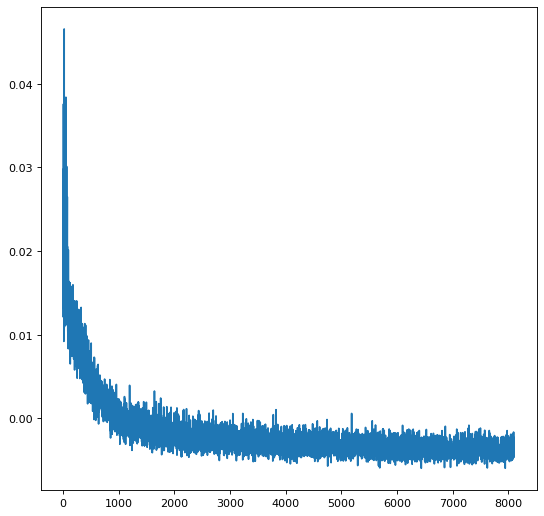

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_0[1:])
plt.show

<function matplotlib.pyplot.show>

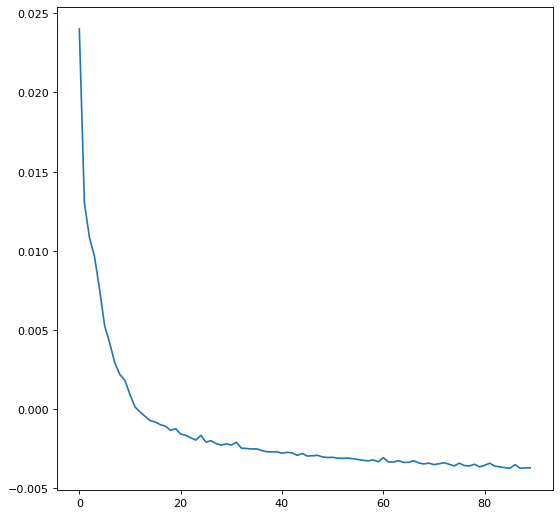

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_0)
plt.show

In [ ]:
import csv
with open('validation_0.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])


In [120]:
import csv
with open('loss_0.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [ ]:
for h in range(0,len(validation_0)):
  with open('validation_0.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_0[h].numpy()])

In [121]:
for h in range(0,len(losses_0)):
  with open('loss_0.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_0[h].numpy()])

In [122]:
import pandas as pd
v = pd.read_csv("/content/loss_0.csv")

In [123]:
v

,batch,loss
0,0,-0.006466
1,1,0.018512
2,2,0.028288
3,3,0.013895
4,4,0.015791
...,...,...
8096,8096,-0.004354
8097,8097,-0.004692
8098,8098,-0.003946
8099,8099,-0.003179


In [ ]:
'''Training - hold out fold 1 for validation'''
#Training
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_1
train_names = set_1
EPOCH=30

In [ ]:
losses_1, validation_1=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.003956
recons_loss:0.003948
grad_loss:0.104285
dice_loss:-0.894721
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.002350
recons_loss:0.005475
grad_loss:0.114040
dice_loss:-0.896521
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.004727
recons_loss:0.003420
grad_loss:0.086971
dice_loss:-0.901687
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.004575
recons_loss:0.003699
grad_loss:0.082821
dice_loss:-0.910167
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.003985
recons_loss:0.003924
grad_loss:0.092507
dice_loss:-0.883442
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.002917
recons_loss:0.004785
grad_loss:0.118586
dice_loss:-0.888793
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.004062
recons_loss:0.00

<function matplotlib.pyplot.show>

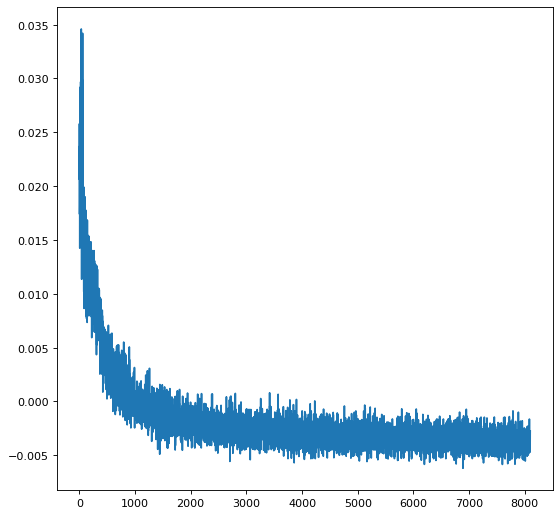

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_1[1:])
plt.show

<function matplotlib.pyplot.show>

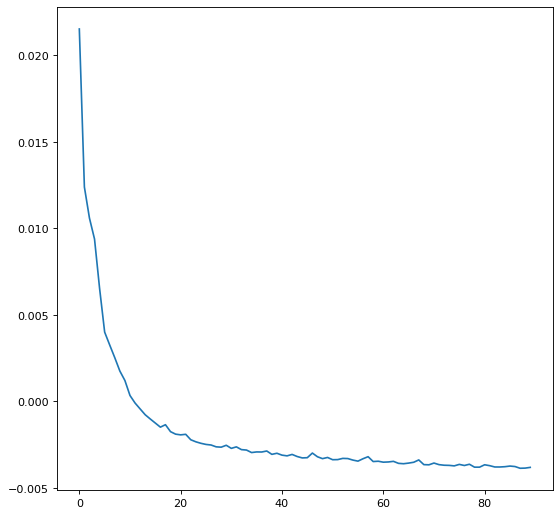

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_1)
plt.show

In [ ]:
import csv
with open('validation_1.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])


In [ ]:
for h in range(0,len(validation_0)):
  with open('validation_1.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_1[h].numpy()])

In [124]:
import csv
with open('loss_1.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_1)):
  with open('loss_1.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_1[h].numpy()])

In [ ]:
'''Training - hold out fold 2 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_2
train_names = set_2
EPOCH=30

In [ ]:
losses_2, validation_2=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.003770
recons_loss:0.004202
grad_loss:0.090207
dice_loss:-0.887428
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.004284
recons_loss:0.003661
grad_loss:0.105373
dice_loss:-0.899784
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.004089
recons_loss:0.003883
grad_loss:0.085634
dice_loss:-0.882828
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.002562
recons_loss:0.005051
grad_loss:0.122747
dice_loss:-0.884105
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.004252
recons_loss:0.003636
grad_loss:0.094261
dice_loss:-0.883012
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.004103
recons_loss:0.003820
grad_loss:0.097279
dice_loss:-0.889577
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.003511
recons_loss:0.00

<function matplotlib.pyplot.show>

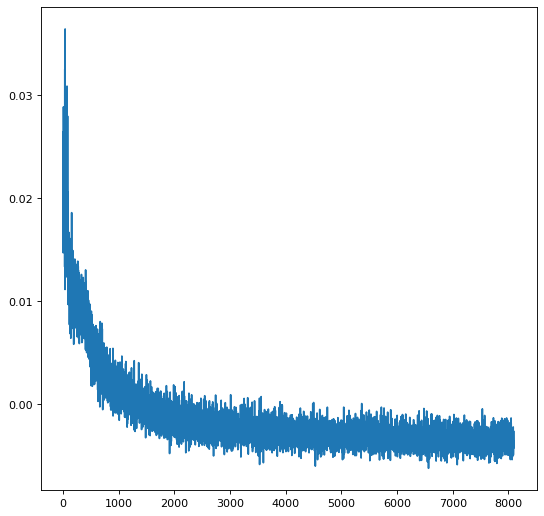

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_2[1:])
plt.show

<function matplotlib.pyplot.show>

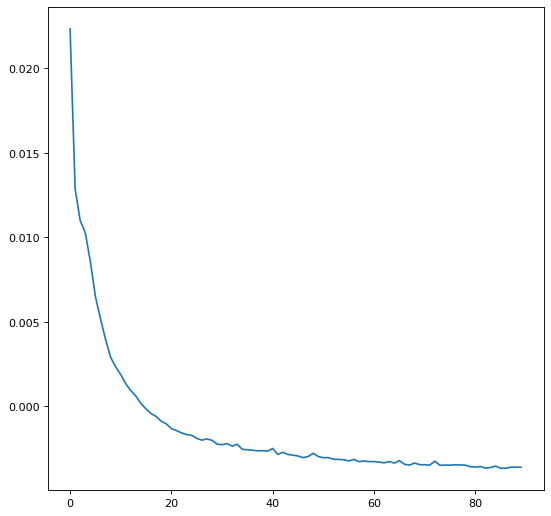

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_2)
plt.show

In [ ]:
import csv
with open('validation_2.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [ ]:
for h in range(0,len(validation_0)):
  with open('validation_2.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_2[h].numpy()])

In [125]:
import csv
with open('loss_2.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_2)):
  with open('loss_2.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_2[h].numpy()])

In [56]:
'''Training - hold out fold 3 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_3
train_names = set_3
EPOCH=30

In [57]:
losses_3, validation_3=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.002917
recons_loss:0.004924
grad_loss:0.104801
dice_loss:-0.888907
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.003888
recons_loss:0.004133
grad_loss:0.093532
dice_loss:-0.895630
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.003181
recons_loss:0.004599
grad_loss:0.115260
dice_loss:-0.893198
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.003464
recons_loss:0.004290
grad_loss:0.100895
dice_loss:-0.876276
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.004741
recons_loss:0.003350
grad_loss:0.082944
dice_loss:-0.892087
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.003129
recons_loss:0.004571
grad_loss:0.096688
dice_loss:-0.866665
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.004993
recons_loss:0.00

<function matplotlib.pyplot.show>

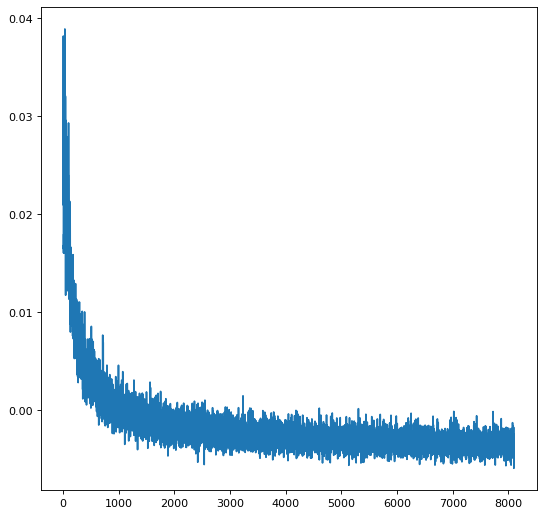

In [58]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_3[1:])
plt.show

<function matplotlib.pyplot.show>

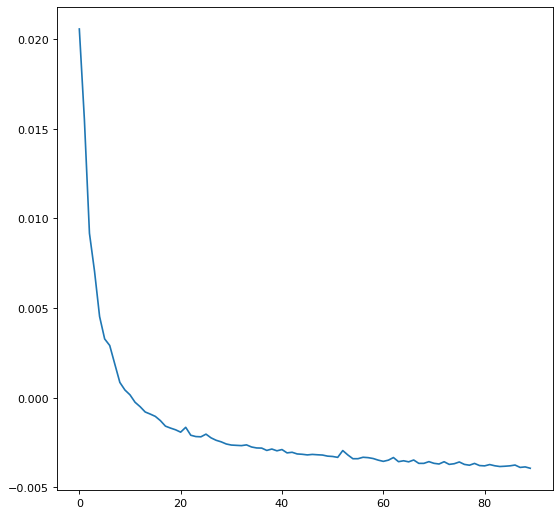

In [59]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_3)
plt.show

In [60]:
import csv
with open('validation_3.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [61]:
for h in range(0,len(validation_0)):
  with open('validation_3.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_3[h].numpy()])

In [126]:
import csv
with open('loss_3.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_3)):
  with open('loss_3.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_3[h].numpy()])

In [62]:
'''Training - hold out fold 4 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_4
train_names = set_4
EPOCH=30

In [63]:
losses_4, validation_4=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.004319
recons_loss:0.003478
grad_loss:0.104997
dice_loss:-0.884658
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.002878
recons_loss:0.004900
grad_loss:0.103396
dice_loss:-0.881262
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.004564
recons_loss:0.003548
grad_loss:0.079176
dice_loss:-0.890334
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.002901
recons_loss:0.004937
grad_loss:0.098686
dice_loss:-0.882466
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.003784
recons_loss:0.004131
grad_loss:0.092360
dice_loss:-0.883864
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.002927
recons_loss:0.004697
grad_loss:0.093830
dice_loss:-0.856158
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.002681
recons_loss:0.00

<function matplotlib.pyplot.show>

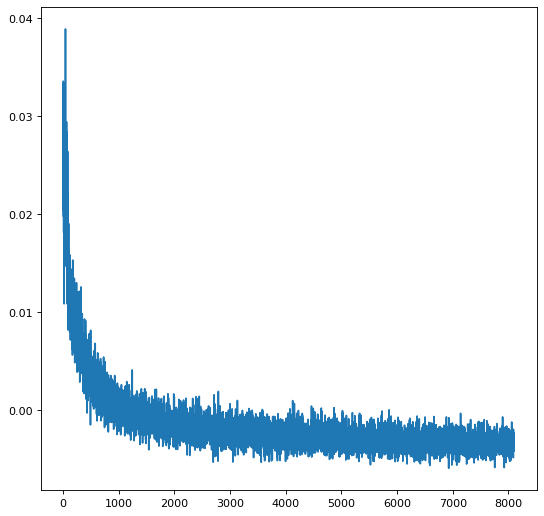

In [64]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_4[1:])
plt.show

<function matplotlib.pyplot.show>

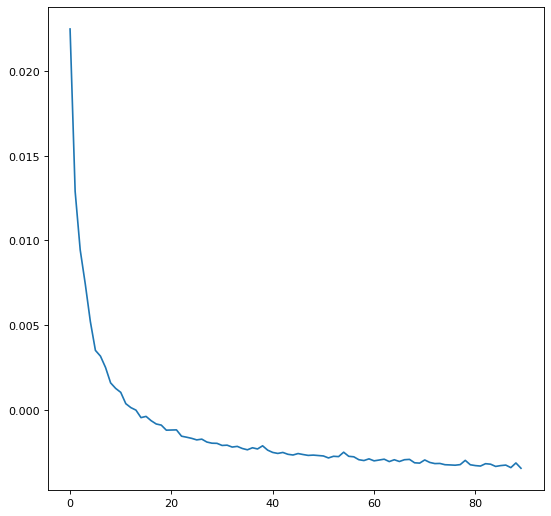

In [65]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_4)
plt.show

In [66]:
import csv
with open('validation_4.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [67]:
for h in range(0,len(validation_0)):
  with open('validation_4.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_4[h].numpy()])

In [127]:
import csv
with open('loss_4.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_4)):
  with open('loss_4.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_4[h].numpy()])

In [68]:
'''Training - hold out fold 5 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_5
train_names = set_5
EPOCH=30

In [69]:
losses_5, validation_5=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.004388
recons_loss:0.003559
grad_loss:0.083641
dice_loss:-0.878285
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.003518
recons_loss:0.004337
grad_loss:0.106212
dice_loss:-0.891757
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.002978
recons_loss:0.004830
grad_loss:0.111850
dice_loss:-0.892668
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.004500
recons_loss:0.003672
grad_loss:0.074249
dice_loss:-0.891478
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.002640
recons_loss:0.005256
grad_loss:0.102587
dice_loss:-0.892228
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.004430
recons_loss:0.003578
grad_loss:0.083888
dice_loss:-0.884701
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.002630
recons_loss:0.00

<function matplotlib.pyplot.show>

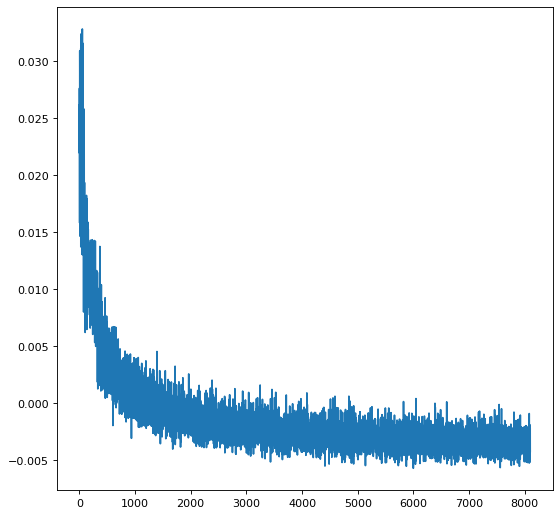

In [70]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_5[1:])
plt.show

<function matplotlib.pyplot.show>

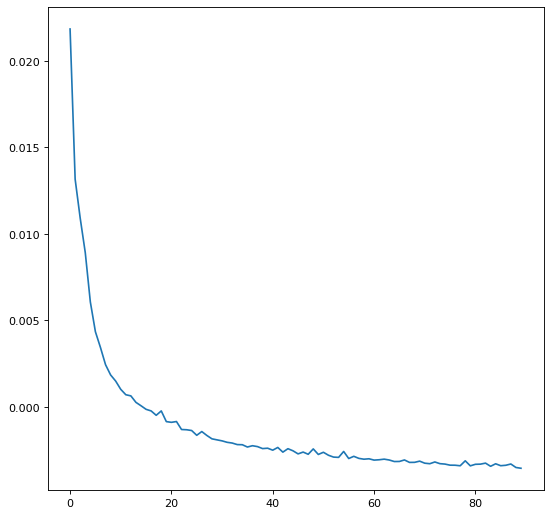

In [71]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_5)
plt.show

In [72]:
import csv
with open('validation_5.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [73]:
for h in range(0,len(validation_0)):
  with open('validation_5.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_5[h].numpy()])

In [128]:
import csv
with open('loss_5.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_5)):
  with open('loss_5.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_5[h].numpy()])

In [74]:
'''Training - hold out fold 6 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_6
train_names = set_6
EPOCH=30

In [75]:
losses_6, validation_6=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.002724
recons_loss:0.005104
grad_loss:0.103125
dice_loss:-0.885925
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.002390
recons_loss:0.005203
grad_loss:0.105084
dice_loss:-0.864408
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.003067
recons_loss:0.004900
grad_loss:0.097072
dice_loss:-0.893818
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.003289
recons_loss:0.004476
grad_loss:0.085148
dice_loss:-0.861692
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.003091
recons_loss:0.004651
grad_loss:0.096304
dice_loss:-0.870530
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.003570
recons_loss:0.004244
grad_loss:0.094160
dice_loss:-0.875522
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.003315
recons_loss:0.00

<function matplotlib.pyplot.show>

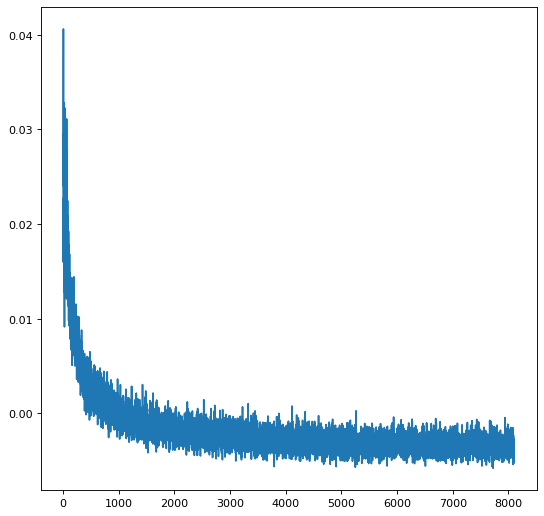

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_6[1:])
plt.show

<function matplotlib.pyplot.show>

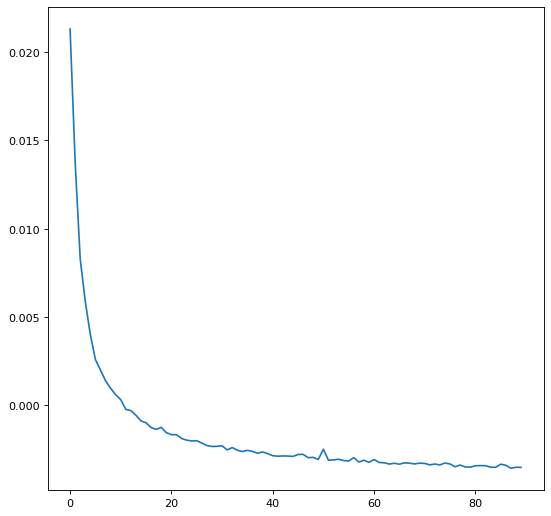

In [ ]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_6)
plt.show

In [76]:
import csv
with open('validation_6.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [77]:
for h in range(0,len(validation_0)):
  with open('validation_6.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_6[h].numpy()])

In [129]:
import csv
with open('loss_6.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_6)):
  with open('loss_6.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_6[h].numpy()])

In [78]:
'''Training - hold out fold 7 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_7
train_names = set_7
EPOCH=30

In [79]:
losses_7, validation_7=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.003426
recons_loss:0.004279
grad_loss:0.114125
dice_loss:-0.884625
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.003730
recons_loss:0.004085
grad_loss:0.091460
dice_loss:-0.872870
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.002165
recons_loss:0.005364
grad_loss:0.121960
dice_loss:-0.874849
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.002409
recons_loss:0.005283
grad_loss:0.119333
dice_loss:-0.888546
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.004644
recons_loss:0.003548
grad_loss:0.081201
dice_loss:-0.900396
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.002599
recons_loss:0.004966
grad_loss:0.113088
dice_loss:-0.869583
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.003155
recons_loss:0.00

<function matplotlib.pyplot.show>

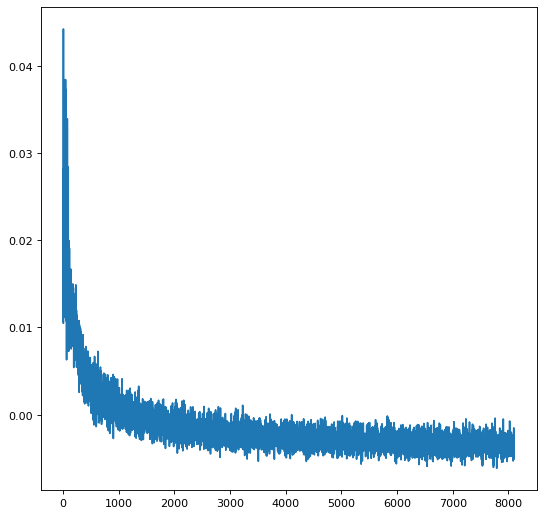

In [80]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_7[1:])
plt.show

<function matplotlib.pyplot.show>

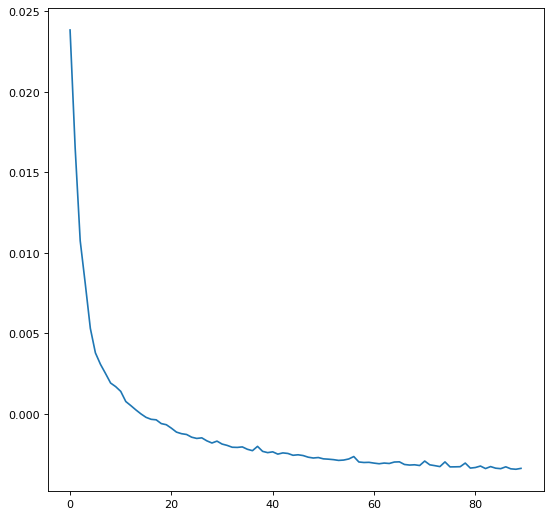

In [81]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_7)
plt.show

In [82]:
import csv
with open('validation_7.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [83]:
for h in range(0,len(validation_0)):
  with open('validation_7.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_7[h].numpy()])

In [130]:
import csv
with open('loss_7.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_7)):
  with open('loss_7.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_7[h].numpy()])

In [84]:
'''Training - hold out fold 8 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_8
train_names = set_8
EPOCH=30

In [85]:
losses_8, validation_8=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.004819
recons_loss:0.003412
grad_loss:0.065821
dice_loss:-0.888872
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.004427
recons_loss:0.003636
grad_loss:0.089598
dice_loss:-0.895950
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.003654
recons_loss:0.004207
grad_loss:0.103109
dice_loss:-0.889275
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.004760
recons_loss:0.003303
grad_loss:0.090239
dice_loss:-0.896510
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.004333
recons_loss:0.003765
grad_loss:0.091175
dice_loss:-0.901039
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.003314
recons_loss:0.004790
grad_loss:0.087161
dice_loss:-0.897588
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.003938
recons_loss:0.00

<function matplotlib.pyplot.show>

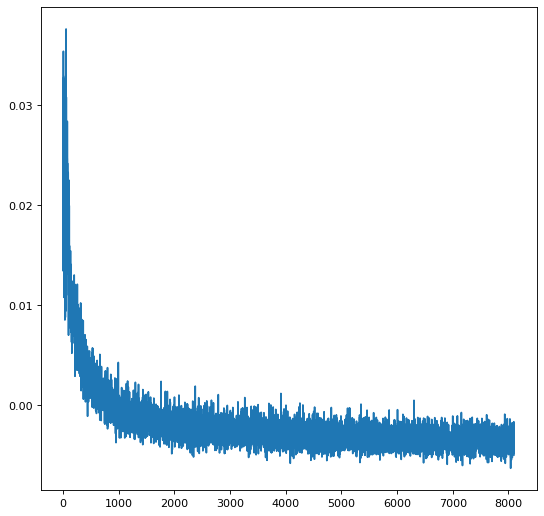

In [86]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_8[1:])
plt.show

<function matplotlib.pyplot.show>

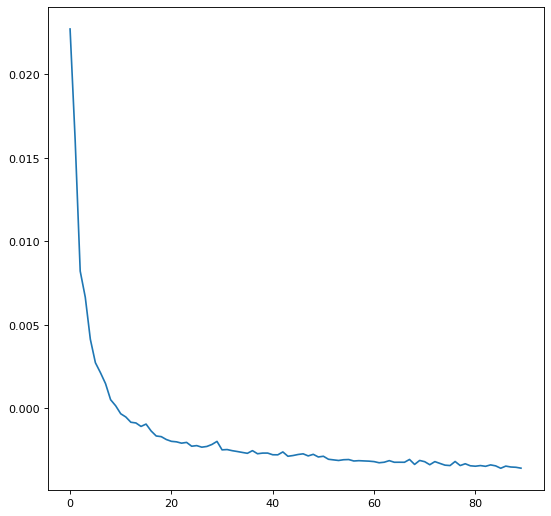

In [87]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_8)
plt.show

In [88]:
import csv
with open('validation_8.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [89]:
for h in range(0,len(validation_0)):
  with open('validation_8.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_8[h].numpy()])

In [131]:
import csv
with open('loss_8.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_8)):
  with open('loss_8.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_8[h].numpy()])

In [90]:
'''Training - hold out fold 9 for validation'''
#Training
gpu='0'
atlas_file='/content/drive/My Drive/2020/Thesis/Data/atlas.npz'
lr=1e-4
n_iter=5000
data_loss='mse'
model='vm2'
reg_param=0.01
batch_size=10
n_save_iter=100
model_dir='/content/drive/My Drive/2020/Thesis/Data/validation_0/'
valid = fold_9
train_names = set_9
EPOCH=30

In [91]:
losses_9, validation_9=validate.train(data_dir,
          train_names,
          atlas_file,
          lr,
          data_loss,
          model,
          reg_param, 
          batch_size,
          n_save_iter,
          model_dir,Net(),EPOCH, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Streaming output truncated to the last 5000 lines.
Batch_number:185
loss(total):-0.004202
recons_loss:0.004012
grad_loss:0.076595
dice_loss:-0.898003
---------------------------------------

Epoch:27
Batch_number:186
loss(total):-0.004387
recons_loss:0.003618
grad_loss:0.085838
dice_loss:-0.886271
---------------------------------------

Epoch:27
Batch_number:187
loss(total):-0.002323
recons_loss:0.005112
grad_loss:0.140468
dice_loss:-0.883881
---------------------------------------

Epoch:27
Batch_number:188
loss(total):-0.003159
recons_loss:0.004703
grad_loss:0.106914
dice_loss:-0.893089
---------------------------------------

Epoch:27
Batch_number:189
loss(total):-0.003854
recons_loss:0.003970
grad_loss:0.102124
dice_loss:-0.884557
---------------------------------------

Epoch:27
Batch_number:190
loss(total):-0.003718
recons_loss:0.004099
grad_loss:0.106399
dice_loss:-0.888152
---------------------------------------

Epoch:27
Batch_number:191
loss(total):-0.003196
recons_loss:0.00

<function matplotlib.pyplot.show>

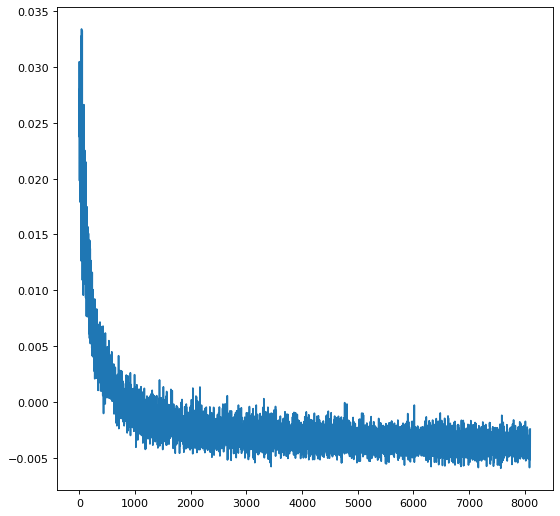

In [92]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(losses_9[1:])
plt.show

<function matplotlib.pyplot.show>

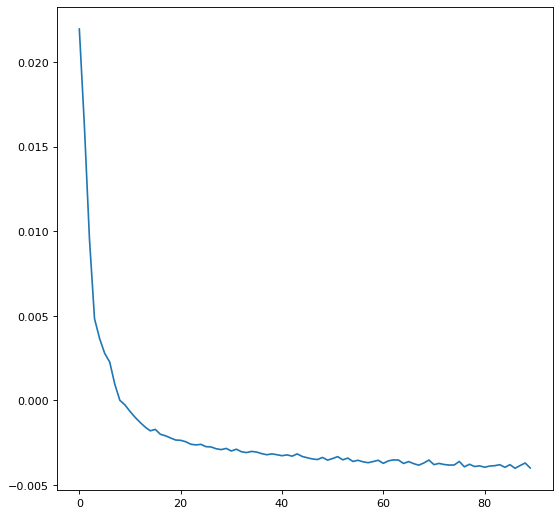

In [93]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(validation_9)
plt.show

In [94]:
import csv
with open('validation_9.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [95]:
for h in range(0,len(validation_0)):
  with open('validation_9.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, validation_9[h].numpy()])

In [133]:
import csv
with open('loss_9.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

for h in range(0,len(losses_9)):
  with open('loss_9.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h, losses_9[h].numpy()])

In [96]:
import statistics

In [110]:
res=[statistics.mean(k) for k in zip(np.array(validation_9), np.array(validation_8),
                                     np.array(validation_7),np.array(validation_6),
                                     np.array(validation_5),np.array(validation_4),
                                     np.array(validation_3),np.array(validation_2),
                                     np.array(validation_1),np.array(validation_0))]

In [111]:
with open('validation_mean.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [112]:
for h in range(0,len(res)):
  with open('validation_mean.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, res[h]])

In [135]:
res_L=[statistics.mean(k) for k in zip(np.array(losses_9), np.array(losses_8),
                                     np.array(losses_7),np.array(losses_6),
                                     np.array(losses_5),np.array(losses_4),
                                     np.array(losses_3),np.array(losses_2),
                                     np.array(losses_1),np.array(losses_0))]

In [136]:
with open('loss_mean.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['batch', 'loss'])

In [137]:
for h in range(0,len(res_L)):
  with open('loss_mean.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([h*100, res_L[h]])

In [138]:
v = pd.read_csv("/content/loss_mean.csv")

In [139]:
v

,batch,loss
0,0,-25.146187
1,100,0.024488
2,200,0.023011
3,300,0.022135
4,400,0.022822
...,...,...
8096,809600,-0.003227
8097,809700,-0.003942
8098,809800,-0.003954
8099,809900,-0.003229


<function matplotlib.pyplot.show>

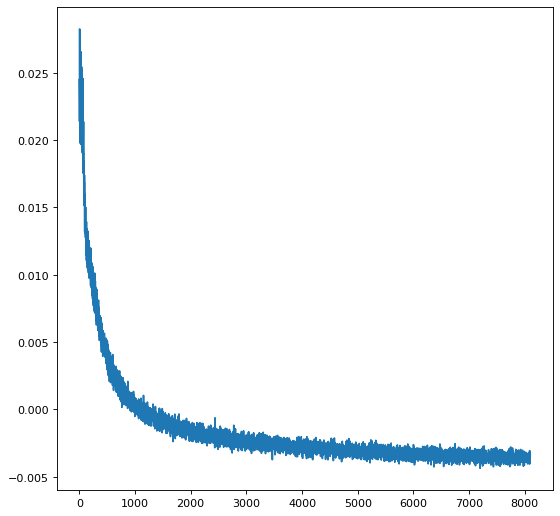

In [140]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(res_L[1:])
plt.show

<function matplotlib.pyplot.show>

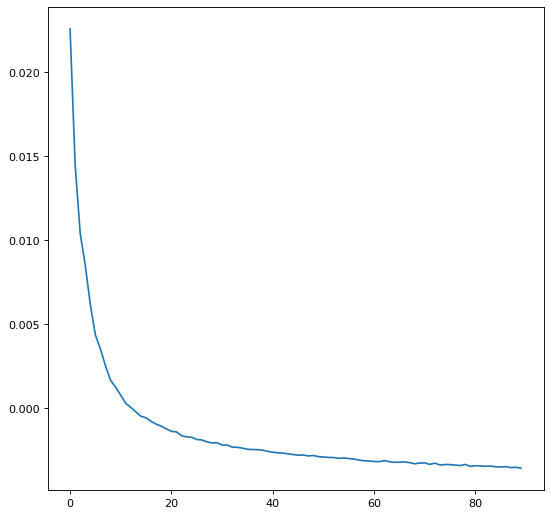

In [141]:
fig=plt.figure(figsize=(8,8),dpi=80,facecolor='w',edgecolor='k')
plt.plot(res)
plt.show